In [2]:
import anndata
import numpy as np
from ALLCools.clustering import *
from sklearn.decomposition import PCA, TruncatedSVD

import matplotlib.pyplot as plt

In [3]:
n_train_cell = 100000
ref_dataset = "mc"

## Merge Adata

In [4]:
if ref_dataset.lower() == 'mc':
    ref_adata = anndata.read_h5ad("mc_input.h5ad")
    query_adata = anndata.read_h5ad("merfish_input.h5ad")
    batch_categories=["mC", "merfish"]
else:
    ref_adata = anndata.read_h5ad("merfish_input.h5ad")
    query_adata = anndata.read_h5ad("mc_input.h5ad")
    batch_categories=["merfish", "mC"]

In [5]:
# the _inplace_subset_var consumes peak memory, 220G for 3.6M cell * 3318 features
use_var = ref_adata.var_names.intersection(query_adata.var_names)
ref_adata._inplace_subset_var(use_var)
query_adata._inplace_subset_var(use_var)

In [6]:
adata_merge = ref_adata.concatenate(
    query_adata, batch_categories=batch_categories, batch_key="Modality", index_unique=None
)
adata_merge

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 60198 × 448
    obs: 'blank_count', 'n_counts', 'n_genes', 'Modality'
    var: 'chrom-mC', 'cov_mean-mC', 'end-mC', 'start-mC', 'cef-mC', 'id-merfish'

In [7]:
np.random.seed(0)

# select mC cells to fit the model
train_cell = np.zeros(ref_adata.shape[0], dtype=bool)
if ref_adata.shape[0] > n_train_cell:
    train_cell[
        np.random.choice(np.arange(ref_adata.shape[0]), n_train_cell, False)
    ] = True
else:
    train_cell[:] = True

ref_adata.obs["Train"] = train_cell.copy()

## Run PCA on ref Adata

In [8]:
n_feature = ref_adata.shape[1]
if n_feature >= 100:
    model = TruncatedSVD(n_components=100, random_state=0, algorithm='randomized')
else:
    model = TruncatedSVD(n_components=n_feature - 1, random_state=0, algorithm='randomized')

# use selected mC cells to fit
model.fit(ref_adata.X[ref_adata.obs["Train"].values])
sel_dim = model.singular_values_ != 0
print(sel_dim.sum(), 'non-zero singular values')

100 non-zero singular values


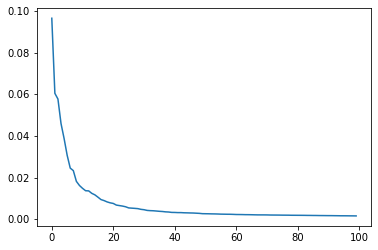

In [9]:
fig, ax = plt.subplots()
ax.plot(model.explained_variance_ratio_)

In [10]:
# transform all other data
chunk_size = 50000
chunks = []
for chunk_start in range(0, adata_merge.shape[0], chunk_size):
    chunks.append(
        model.transform(adata_merge.X[chunk_start : (chunk_start + chunk_size)])
    )

# add NNZ PCs to adata
adata_merge.obsm["X_pca"] = np.concatenate(chunks, axis=0)[:, sel_dim]

# remove low variance PCs
n_pcs = significant_pc_test(adata_merge, p_cutoff=0.05, obsm="X_pca")

# scale PC by singular values
adata_merge.obsm["X_pca"] /= model.singular_values_[sel_dim][:n_pcs]

Downsample PC matrix to 50000 cells to calculate significant PC components
50 components passed P cutoff of 0.05.
Changing adata.obsm['X_pca'] from shape (60198, 100) to (60198, 50)


In [11]:
for m in ["mC", "merfish"]:
    adata = adata_merge[adata_merge.obs["Modality"] == m]
    adata.write_h5ad(f"{m.lower()}_pca.h5ad")

In [12]:
import subprocess
subprocess.run(['rm', '-f', 'mc_input.h5ad', 'merfish_input.h5ad'])

CompletedProcess(args=['rm', '-f', 'mc_input.h5ad', 'merfish_input.h5ad'], returncode=0)